In [1]:
import os
import re
import math
from collections import defaultdict
import pandas as pd
import numpy as np
import branca
import json
import folium
import quandl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

from IPython.core.display import display, HTML

# Turn slice copy warnings off
pd.options.mode.chained_assignment = None

Let us first read in the data, put it in the format we want and write it to a new file to read it faster the next time

In [ ]:
#Read the data for all different boroughs
#All the files have the same format since they originate from the same source
df1 = pd.read_excel('./data/housing/rollingsales_manhattan.xls', header = 4)
df2 = pd.read_excel('./data/housing/rollingsales_queens.xls', header = 4)
df3 = pd.read_excel('./data/housing/rollingsales_brooklyn.xls', header = 4)
df4 = pd.read_excel('./data/housing/rollingsales_statenisland.xls', header = 4)
df5 = pd.read_excel('./data/housing/rollingsales_bronx.xls', header = 4)

#Put all data in one dataframe
df = df1.append(df2).append(df3).append(df4).append(df5)

#Write to csv to read it faster in future steps
df.to_csv('./data/housing/rollingsales_NYC.csv', index=False)

In [2]:
#Read data from csv
df = pd.read_csv('./data/housing/rollingsales_NYC.csv')

In [3]:
#Look at what data we have available
df.dtypes

BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                   int64
GROSS SQUARE FEET                  int64
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                         int64
SALE DATE                         object
dtype: object

Some features have weird data format. It doesn't make sense to represent features as int64 when they are not being used for mathematical processing. That's why we will first transform that data

In [4]:
df = df.astype({"BLOCK": str, "LOT": str, "ZIP CODE": str, "TAX CLASS AT TIME OF SALE": str});

id_borough = {1: "Manhattan", 2: "Bronx", 3:"Brooklyn", 4:"Queens", 5:"Staten Island"}
df = df.replace({"BOROUGH": id_borough})

We want to create a metric that indicates how affordable it is to live somewhere. Of course it is interesting to look at the sale price but this obviously depends on the living surface you get for it. That's why we will also look at the Gross Square Feet and the Number Of Units involved in the sale

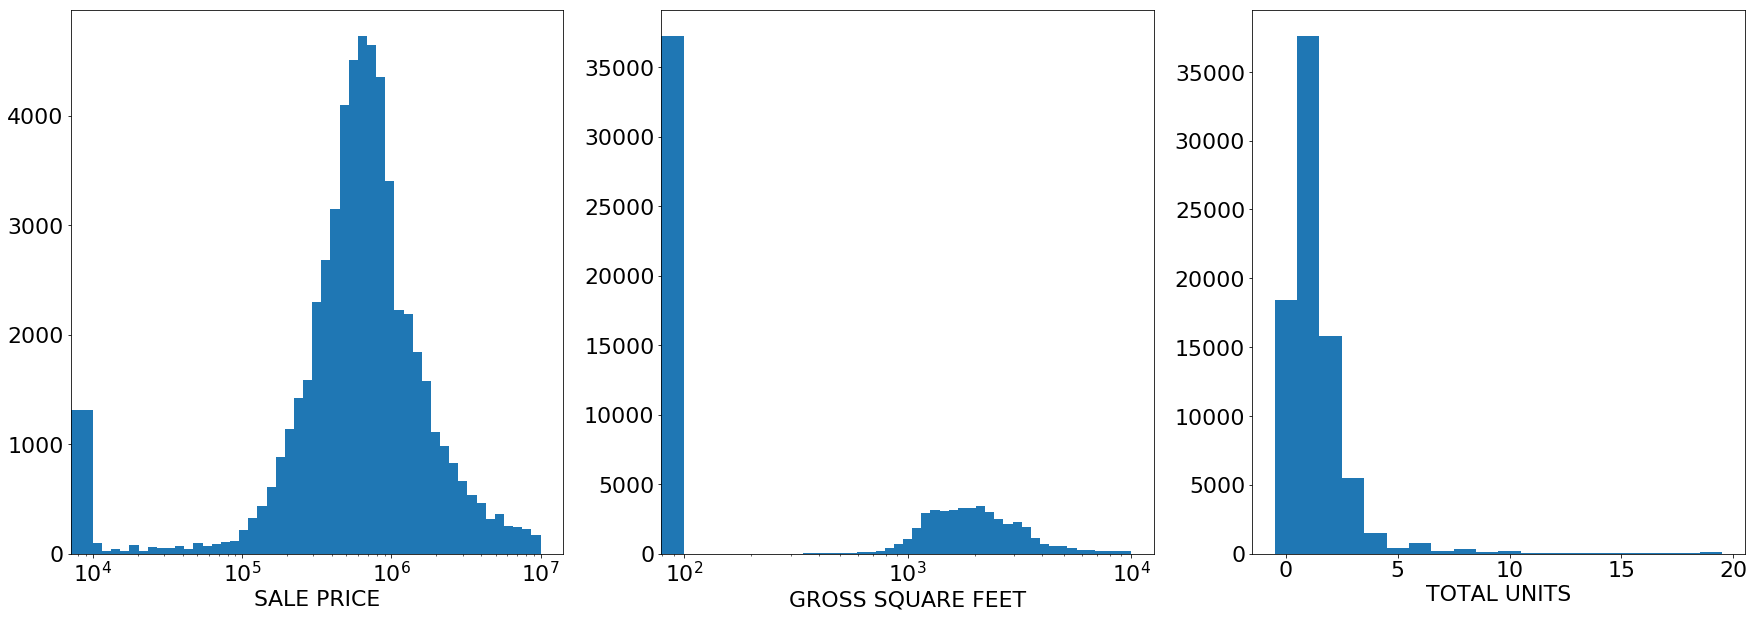

In [5]:
#Function to create bins with boundaries on the integer log axis
#This function is eventually not used
def log_bins(min_log=0, max_log=10, zero=True):
    bins_temp = np.linspace(1,9, num=9)
    bins = np.array([])
    for i in range(min_log, max_log):
        bins = np.append(bins, bins_temp*np.power(10,i))
    if(zero):
        bins = np.insert(bins, 0, 0, axis=0)
    return bins
    
plt.rcParams.update({'font.size': 22})

#Histogram of sale prices
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.hist(df[df['SALE PRICE']>0 ]['SALE PRICE'], bins = np.insert(np.logspace(4, 7, 50), 0,0, axis=0))
plt.xscale("log");
plt.xlabel("SALE PRICE");

#Histogram of gross square feet in the building involved in the sale
plt.subplot(1,3,2)
plt.hist(df['GROSS SQUARE FEET'], bins = np.insert(np.logspace(2, 4, 50), 0,0, axis=0))
plt.xscale("log");
plt.xlabel("GROSS SQUARE FEET");

#Histogram of the number of units involved in the sale
plt.subplot(1,3,3)
plt.hist(df['TOTAL UNITS'], bins = np.insert(np.linspace(0, 20, 21), 0,0, axis=0), align='left');
plt.xlabel("TOTAL UNITS");

We see that most of the sales happend for an amount between 100K \\$ and 10M \\$. We also see that some houses were sold for less than 100K. As we don't think it is realistic to buy a house or appratment in NYC for less then 100K\\$ or even 0\\$, we decide not to take these transactions into account. For example a lot of them are sales of 1$ so either something fishy is going on there or a mistake was made when entering the data.

When looking at the Gross Square Feet, we see that for a lot of entries, this data is missing. We will of course not take into account entries which have a surface area of 0 to live on.

The same holds for the number of units. It doesn't make sense to pay for a house with zero units to live in so that is why we will just ignore these. One remark that could be made here is that we do not make a difference residential units and commercial units. Normally we should only take into account the residential ones since we are focussing on families wanting to live in NYC. It is however not feasible to estimate a number to subtract from the sales price to get the value of the residential units. Thats why, when evaluating this metric, we only take into account sales in which the number of residential units is bigger than the number of commercial units

In [6]:
nrResidentialUnits = df['RESIDENTIAL UNITS'].sum()
nrCommercialUnits = df['COMMERCIAL UNITS'].sum()
nrTotalUnits = df['TOTAL UNITS'].sum()

ratioRes = nrResidentialUnits / nrTotalUnits;
ratioCom = nrCommercialUnits / nrTotalUnits;

print("Total number of residential units: "+str(nrResidentialUnits)+ " ("+str(round(ratioRes*100,2))+"% of total units)")
print("Total number of commercial units: "+str(nrCommercialUnits)+ " ("+str(round(ratioCom*100,2))+"% of total units)")

print("\n\nNow only look at the sales in which at least one residential unit per sale was involved. \n\
So ignore the sales in which only commercial units were involved \n")

df_temp = df[df['RESIDENTIAL UNITS']>df['COMMERCIAL UNITS']]

nrResidentialUnits = df_temp['RESIDENTIAL UNITS'].sum()
nrCommercialUnits = df_temp['COMMERCIAL UNITS'].sum()
nrTotalUnits = df_temp['TOTAL UNITS'].sum()

ratioRes = nrResidentialUnits / nrTotalUnits;
ratioCom = nrCommercialUnits / nrTotalUnits

print("Total number of residential units: "+str(nrResidentialUnits)+ " ("+str(round(ratioRes*100,2))+"% of total units)")
print("Total number of commercial units: "+str(nrCommercialUnits)+ " ("+str(round(ratioCom*100,2))+"% of total units)")

Total number of residential units: 156385 (90.93% of total units)
Total number of commercial units: 13060 (7.59% of total units)


Now only look at the sales in which at least one residential unit per sale was involved. 
So ignore the sales in which only commercial units were involved 

Total number of residential units: 155462 (98.21% of total units)
Total number of commercial units: 2833 (1.79% of total units)


When we look at the number ratio of residential en commercial units in the total dataset, we see that quite a few of them are commercial units. Something strange however is that the total of both types doesn't add up to the number of total units. In the dataset there is nothing mentioned about other types of units. When we think about non-commercial or non-residential units, we think about for example churches, government offices, ... We think this might be the missing units since they cannot be really classified in one the above sections.

As mentioned before we will only take into account the sales in which the number of residential units is larger than the number of commercial units. When applying this filter we see that the ratio of commercial units to total units is drastically reduced. It might be exagerating that it can be neglected but we believe that the eventual dataset will give a representative metric for the user.

In [7]:
# category = 'BUILDING CLASS CATEGORY'

# df_temp  = df[(df['SALE PRICE'] > 1000000) & (df['SALE PRICE'] < 2000000)].groupby(category)['SALE PRICE'].count()
# df_temp2 = df[(df['SALE PRICE'] > 1000000)].groupby(category)['SALE PRICE'].count()
# df_temp3 = df_temp/df_temp2;

# df_temp3 = pd.DataFrame(df_temp3).reset_index()
# df_temp3.columns = ['Borough', 'count']
# df_temp3['NR SALES'] = df_temp2.values

# category = 'BOROUGH'

# fig, ax = plt.subplots()

# cat = df_temp[category].unique()
# y_pos = np.arange(len(people))
# performance = 3 + 10 * np.random.rand(len(people))
# error = np.random.rand(len(people))

# ax.barh(y_pos, performance, xerr=error, align='center',
#         color='green', ecolor='black')
# ax.set_yticks(y_pos)
# ax.set_yticklabels(people)
# ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Performance')
# ax.set_title('How fast do you want to go today?')

In [8]:
boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx']
color_dict = {'Manhattan': 'gold', 'Brooklyn': 'red', 'Queens': 'purple', 'Staten Island': 'green', 'Bronx': 'blue'}

# display(df)
# colors = df_gsf["BOROUGH"].replace(color_dict)

# display(df)
# display(df.iloc[[2]])


# display(df)
# display(colors)

# print(type())
# (colors[i] for i in range(length(df)) if df[]), s in izip(data, selectors) if s)
# colors.values.tolist()[(df['GROSS SQUARE FEET']>0).values]

In [9]:
#Filter data to remove unreliable data
df = df[df['SALE PRICE'] > 100000]
df_gsf = df[df['GROSS SQUARE FEET']>0]
df_unit = df[df['RESIDENTIAL UNITS']>df['COMMERCIAL UNITS']]

#Add new metrics on which to evaluate affordability
df_gsf['PRICE PER SQUARE FOOT'] = df_gsf['SALE PRICE']/df_gsf['GROSS SQUARE FEET']
df_unit['PRICE PER UNIT'] = df_unit['SALE PRICE']/df_unit['TOTAL UNITS']

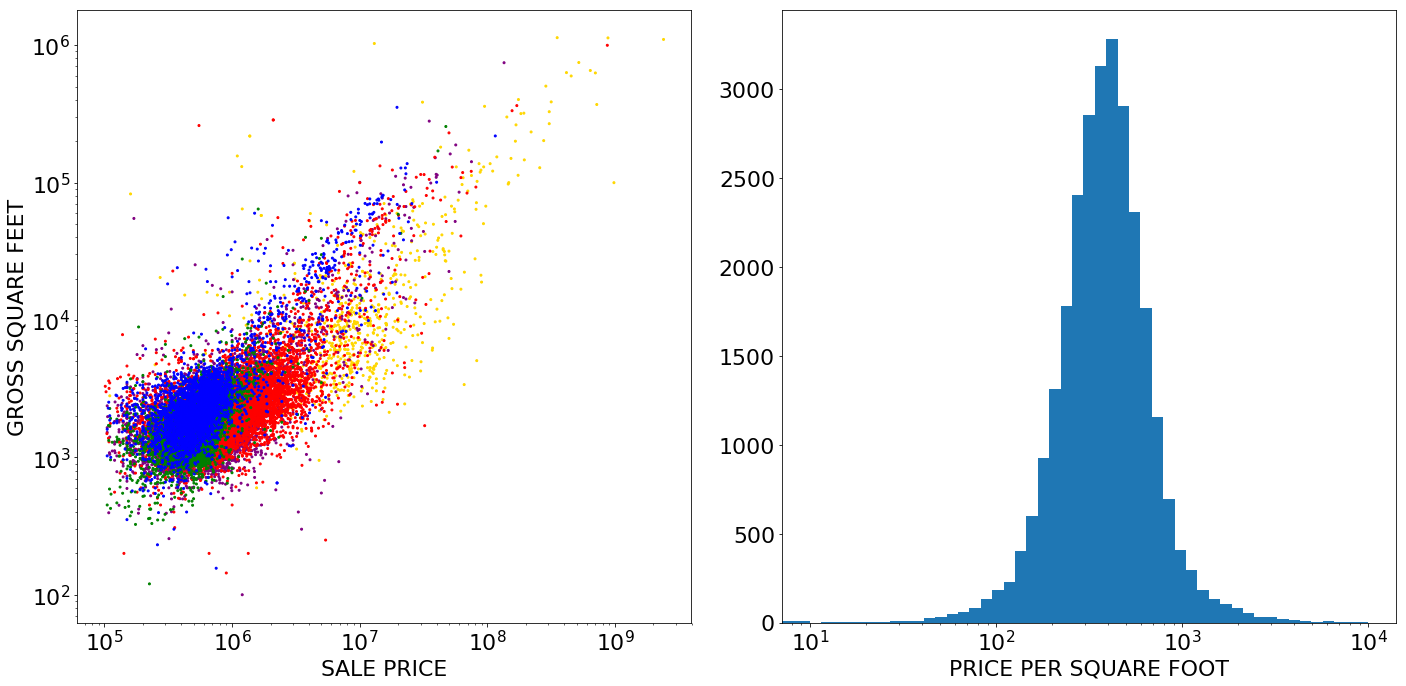

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(df_gsf['SALE PRICE'], df_gsf['GROSS SQUARE FEET'], c=df_gsf["BOROUGH"].replace(color_dict).values.tolist(), s=4)
plt.xlabel("SALE PRICE")
plt.ylabel("GROSS SQUARE FEET")
plt.xscale("log")
plt.yscale("log")

plt.subplot(1,2,2)
plt.hist(df_gsf['PRICE PER SQUARE FOOT'], bins = np.insert(np.logspace(1, 4, 50), 0,0, axis=0));
plt.xscale("log");
plt.xlabel("PRICE PER SQUARE FOOT");

plt.tight_layout()
plt.show()


When we compare the sale prices with the gross square feet, we see that there is a linear correlation. There are not real outliers where for example some extreme cheap sale went through.

Most of the sales cost about 500\$ per square foot which is about 5400\\$ per square meter.

Now let's have a look at how these results differ for different neighbourhouds, i.e. different ZIP Codes.
To give each neighbourhood a score between zero and one, we just choose the cumulative probability that another neighbourhood in NYC has a lower average prices per square foot

In [11]:
#Group everything by zip code to get a metric per zip code
df_gsf_grouped = df_gsf.groupby(['ZIP CODE'])[['SALE PRICE', 'GROSS SQUARE FEET']].sum()
df_gsf_grouped['PRICE PER SQUARE FOOT'] = df_gsf_grouped['SALE PRICE']/df_gsf_grouped['GROSS SQUARE FEET']

#Create cumulative distribution -> Eventual metric
df_gsf_grouped['PPSQ SCORE'] = 1-df_gsf_grouped['PRICE PER SQUARE FOOT'].rank()/len(df_gsf_grouped['PRICE PER SQUARE FOOT'])
df_gsf_grouped = df_gsf_grouped.reset_index()

In [12]:
#Create map centered in NYC
pc = folium.Map(location=[40.75, -74]);

#GeoJson map with the edges of both the boroughs and the postal codes
postcode_edge = json.load(open(os.path.join('data', 'nyc-postcode.json')));
borough_edge = json.load(open(os.path.join('data', 'nyc-boroughs.json')));

# print(help(folium.GeoJson))
# print(help(folium.features.GeoJsonTooltip))

# folium.GeoJson(
#         borough_edge,
#         name='Boroughs',
#         style_function = lambda x: {'fillColor': '#0000ff', 'fillOpacity': 0.3},
#         tooltip=folium.features.GeoJsonTooltip(fields=['borough','postalCode'], 
#         aliases=['Borough','Postal Code'],
#         labels=True,
#         sticky=True)
#     ).add_to(pc);


folium.Choropleth(geo_data=postcode_edge,
                  name='Price per square foot',
                  data=df_gsf_grouped,
                  columns=['ZIP CODE', 'PPSQ SCORE'],
                  nan_fill_color='grey',
                  bins = 9,
                  key_on = 'feature.properties.postalCode',
                  fill_color='BuGn',
                  fill_opacity=1,
                  line_opacity=1,
                  highlight=True,
#                   tooltip=folium.features.GeoJsonTooltip(fields=['borough','postalCode'],
#                                                          aliases=['Borough','Postal Code'],
#                                                          labels=True,
#                                                          sticky=True)
                 ).add_to(pc);

folium.GeoJson(
    postcode_edge,
    name='ZIP Codes',
#     style_function = lambda x: {'fillColor': '#00ff00', 'fillOpacity': 0.3},
    tooltip=folium.features.GeoJsonTooltip(fields=['borough','postalCode'], 
    aliases=['Borough','Postal Code'],
    labels=True,
    sticky=True)).add_to(pc);



folium.LayerControl().add_to(pc)


filepath = "./maps/housing/NYC_PPSQ.html"
pc.save(filepath)

pc

[<matplotlib.collections.PathCollection object at 0x000001374783E4E0>, <matplotlib.collections.PathCollection object at 0x0000013747713668>, <matplotlib.collections.PathCollection object at 0x000001374783E358>, <matplotlib.collections.PathCollection object at 0x00000137477138D0>, <matplotlib.collections.PathCollection object at 0x00000137477E8358>]


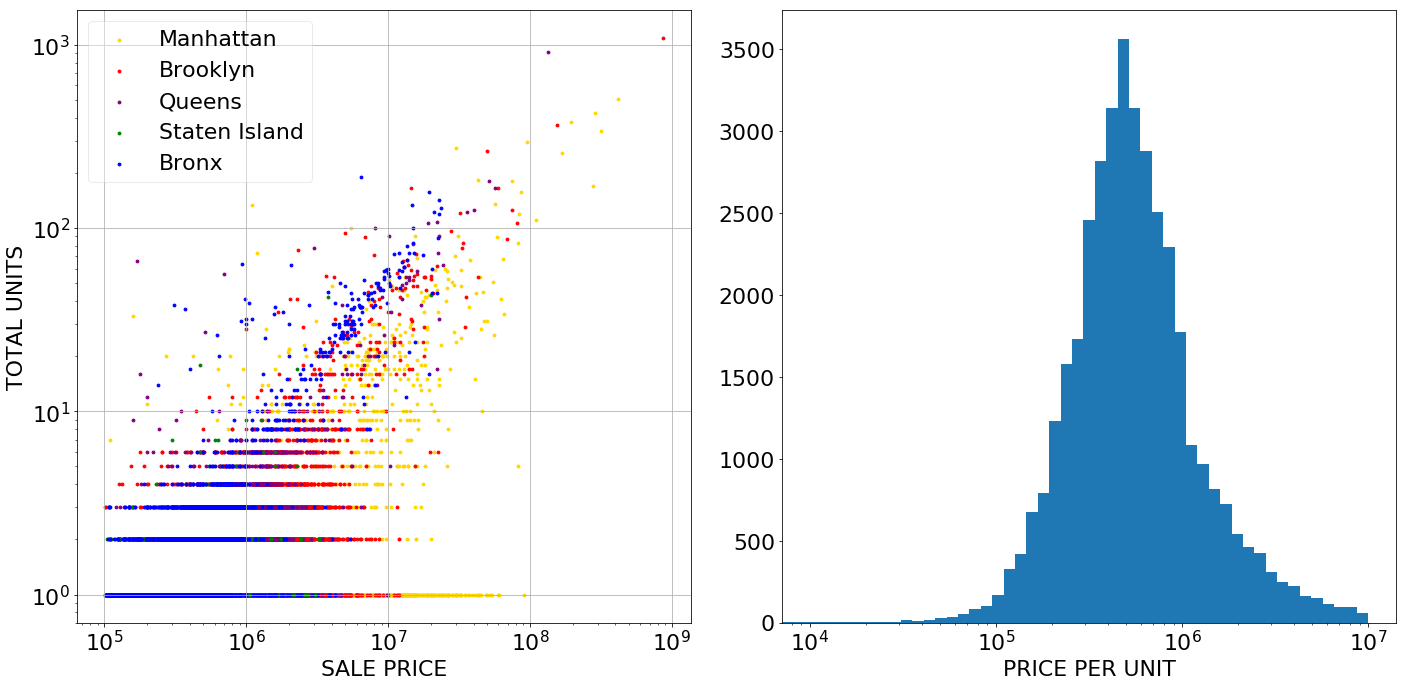

In [13]:
fig = plt.figure(figsize=(20,10))
axes = plt.subplot(1,2,1)
lines = []
for i in boroughs:
    line = axes.scatter(df_unit[df_unit['BOROUGH']==i]['SALE PRICE'], df_unit[df_unit['BOROUGH']==i]['TOTAL UNITS'],
               c=color_dict[i], s=8, label=i)
    lines.append(line)
# plt.scatter(df_unit['SALE PRICE'], df_unit['TOTAL UNITS'], c=df_unit["BOROUGH"].replace(color_dict).values.tolist(), s=4)
print(lines)
# line1leg, = ax.plot(0, 0, lw=2, c='r', label='1 HZ')
# line2leg, = ax.plot(0, 0, lw=2, c='b', label='2 HZ')
# line1, = ax.plot(t, y1, 'ro', lw=0, label='_nolegend_')
# line2, = ax.plot(t, y2, 'bo', lw=0, label='_nolegend_')
plt.xlabel("SALE PRICE")
plt.ylabel("TOTAL UNITS")
plt.xscale("log")
plt.yscale("log")
leg = axes.legend(loc='upper left', fancybox=True)
leg.get_frame().set_alpha(0.4)
plt.grid(True)

lined = dict()
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(5)  # 5 pts tolerance
    lined[legline] = origline
    
def onpick(event):
    # on the pick event, find the orig line corresponding to the
    # legend proxy line, and toggle the visibility
    legline = event.artist
    origline = lined[legline]
    vis = not origline.get_visible()
    origline.set_visible(vis)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled
    if vis:
        legline.set_alpha(1.0)
    else:
        legline.set_alpha(0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', onpick)

plt.subplot(1,2,2)
plt.hist(df_unit['PRICE PER UNIT'], bins = np.insert(np.logspace(4, 7, 50), 0,0, axis=0));
plt.xscale("log");
plt.xlabel("PRICE PER UNIT");

plt.tight_layout()
plt.show()


In [ ]:
df_unit_grouped = df_unit.groupby(['ZIP CODE'])[['SALE PRICE', 'TOTAL UNITS']].sum()
df_unit_grouped['PRICE PER UNIT'] = df_unit_grouped['SALE PRICE']/df_unit_grouped['TOTAL UNITS']
df_unit_grouped['PPU SCORE'] = 1-df_unit_grouped['PRICE PER UNIT'].rank()/len(df_unit_grouped['PRICE PER UNIT'])
df_unit_grouped = df_unit_grouped.reset_index()

In [ ]:
pc = folium.Map(location=[40.75, -74]);

postcode_edge = json.load(open(os.path.join('data', 'nyc-postcode.json')));

folium.Choropleth(geo_data=postcode_edge, 
             data=df_unit_grouped,
             columns=['ZIP CODE', 'PPU SCORE'],
             nan_fill_color='grey',
             bins = 9,
             key_on = 'feature.properties.postalCode',
             fill_color='BuGn',
             fill_opacity=0.7,
             line_opacity=0.3,
             highlight=True).add_to(pc);

folium.GeoJson(
    postcode_edge,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['borough','postalCode'], aliases=['Borough','Postal Code'], labels=True, sticky=True)).add_to(pc);


pc

For the dataset filtered on realistic prices, most of the surface areas seem reasonable, besides the ones with surface area zero because this data is missing. We can not take these ones into account when we look at price per square feet.

When we look at the number of units, we see that most of the sales consist of one unit, with some consisting of zero units. These is missing data and should be ignored. There are also some sales that consisted of 10 to even more then 100 units. Probably this were entire appartment buildings that were sold but when dividing the sales price by the number of units, this is still a good evaluation of the prices per unit that a regular user would pay although it could be a small underestimating since the one who buys the appartment building probably wants to gain money by selling the individual appartement a more expensive

In [ ]:
#Read the data for all different boroughs
#All the files have the same format since they originate from the same source
df1 = pd.read_excel('./data/housing/rollingsales_manhattan.xls', header = 4)
df2 = pd.read_excel('./data/housing/rollingsales_queens.xls', header = 4)
df3 = pd.read_excel('./data/housing/rollingsales_brooklyn.xls', header = 4)
df4 = pd.read_excel('./data/housing/rollingsales_statenisland.xls', header = 4)
df5 = pd.read_excel('./data/housing/rollingsales_bronx.xls', header = 4)

#Put all data in one dataframe
df = df1.append(df2).append(df3).append(df4).append(df5)

#Write to csv to read it faster in future steps
df.to_csv('./data/housing/rollingsales_NYC.csv', index=False)

In [ ]:
columns_init =['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE']
columns = ['BOROUGH', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'GROSS SQUARE FEET', 'SALE PRICE', 'SALE DATE']



In [ ]:
for i in range(2003,2019):
   # print(i)
    if(i>2010):
        header_row = 4
    else:
        header_row = 3
    df1 = pd.read_excel('./data/housing/'+str(i)+'_manhattan.xls', header = header_row)
    df2 = pd.read_excel('./data/housing/'+str(i)+'_queens.xls', header = header_row)
    df3 = pd.read_excel('./data/housing/'+str(i)+'_brooklyn.xls', header = header_row)
    df4 = pd.read_excel('./data/housing/'+str(i)+'_statenisland.xls', header = header_row)
    df5 = pd.read_excel('./data/housing/'+str(i)+'_bronx.xls', header = header_row)
    df = df1.append(df2).append(df3).append(df4).append(df5)
    df.columns = columns_init
#     df =df[columns]
    df['SALE YEAR']=i
    
    df.to_csv('./data/housing/'+str(i)+'_NYC.csv', index=False)
   

In [ ]:
df = pd.DataFrame()
for i in range(2003,2019):
    print(i)
    df_temp = pd.read_csv('./data/housing/'+str(i)+'_NYC.csv')
    df = df.append(df_temp)
    

df.to_csv('./data/housing/history_NYC.csv', index=False)
df = df.reset_index()
display(df)
# columns = ['BOROUGH', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'GROSS SQUARE FEET', 'SALE PRICE']
# df = pd.read_csv('./data/housing/2003_NYC.xls')[columns]
# df['SALE YEAR']=2003
# print(df.columns)

In [ ]:
display(df_gsf_grouped[['ZIP CODE', 'PPSQ SCORE']])

df_gsf_grouped[['ZIP CODE', 'PPSQ SCORE']].to_csv('./data/scores/housing.csv', index=False)

In [ ]:
#Read data from csv
df = pd.read_csv('./data/housing/history_NYC.csv')

id_borough = {1: "Manhattan", 2: "Bronx", 3:"Brooklyn", 4:"Queens", 5:"Staten Island"}
df = df.replace({"BOROUGH": id_borough})

#Filter data to remove unreliable data
df = df[df['SALE PRICE'] > 100000]
df_gsf = df[df['GROSS SQUARE FEET']>0]
df_unit = df[df['RESIDENTIAL UNITS']>0]

#Add new metrics on which to evaluate affordability
df_gsf['PRICE PER SQUARE FOOT'] = df_gsf['SALE PRICE']/df_gsf['GROSS SQUARE FEET']
df_unit['PRICE PER UNIT'] = df_unit['SALE PRICE']/df_unit['TOTAL UNITS']

In [ ]:
df_gsf_temp = df_gsf.groupby(by=['BOROUGH', 'SALE YEAR'])[['GROSS SQUARE FEET', 'SALE PRICE']].sum()
df_gsf_temp['PRICE PER SQUARE FOOT'] = df_gsf_temp['SALE PRICE']/df_gsf_temp['GROSS SQUARE FEET']
df_gsf_temp = df_gsf_temp.reset_index()

plt.figure(figsize=(20,10))
for i in ['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']:
    plt.plot(df_gsf_temp[df_gsf_temp['BOROUGH']==i]['SALE YEAR'], df_gsf_temp[df_gsf_temp['BOROUGH']==i]['PRICE PER SQUARE FOOT'])

# display(df_gsf_temp)

Units:
- The sale sometimes consist of one unit while sometimes a whoel building with multiple units is sold. Some buildings include residential units while others might also include commercial units

Square feet:
- A seperation is made between land suqare feet and gross square feet. Gross squarefeet will always be at least as big as land square feet and strictly bigger as soon as you start adding levels to your building

Sale price:
- This is the prices for which the building/unit was sold. There is quite a lot of variation


To establish a metric on the affordability to live somewhere, two options seem interesting, either the prices per square foot or either the price per unit.

We can see that there are a lot of columns which don't have any value for our research purpose. The only thing we want to achieve is to have an idea on the housing prices per borough. We don't care about different buildings/projects since we will aggregate them per borough

There are no duplicate rows in the dataset but there are a quite a lot of rows with Nan Values. Fortunatly, none of the nan-values occur in columns we are interested in.

Below you can find a description of the different columns: 
Extremely Low Income Units are units with rents that are affordable to households earning 0 to 30% of the area median income (AMI).

Very Low Income Units are units with rents that are affordable to households earning 31 to 50% of the area median income (AMI).

Low Income Units are units with rents that are affordable to households earning 51 to 80% of the area median income (AMI).

Moderate Income Units are units with rents that are affordable to households earning 81 to 120% of the area median income (AMI).

Middle Income Units are units with rents that are affordable to households earning 121 to 165% of the area median income (AMI).

Other Units are units reserved for building superintendents.

All these values are based on the Area Median Income. This is a value, describing the median income for a certain size of family in the NYC metropolitan area. For the year 2018, the values were like this:
* \$104.300 - Family of four
* \$ 93.900 - Family of three
* \$ 83.500 - Family of two
* \$ 73.100 - Individual

The category of a unit thus depends on the price of that unit and on the size of the unit